In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
import xgboost as xgb

In [2]:
#load cleaned dataset
df= pd.read_parquet("../data/cleaned_data_2.parquet")
df.head()

,ffb_1%_oer,import,export,production,end_stock,cpo_futures,usd_myr_rate,brent_oil_futures,soybean_futures,precipitation,...,avg_humidity,lag_1,lag_3,lag_7,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30,pct_change_1,pct_change_7
0,21.30,81477,1680891,1737461,3002871,2200.0,4.0960,61.89,30.48,47.5,...,90.083333,21.2,21.20,20.75,21.071429,20.576667,0.209875,0.332113,0.004717,0.026506
1,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,7.0,...,89.958333,21.3,21.25,20.85,21.135714,20.620000,0.199404,0.339015,0.000000,0.021583
2,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,4.7,...,90.083333,21.3,21.20,20.85,21.200000,20.660000,0.160728,0.346261,0.000000,0.021583
3,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,13.2,...,89.125000,21.3,21.30,20.85,21.264286,20.690000,0.047559,0.361606,0.000000,0.021583
4,21.35,94278,1324615,1544518,3056929,2207.0,4.0935,62.51,30.44,6.5,...,88.500000,21.3,21.30,21.20,21.285714,20.721667,0.047559,0.376619,0.002347,0.007075


Split data into Train/Validate/Test Split:

In [3]:
target_col = "ffb_1%_oer"
raw_features = ["import", "export", "production", "end_stock", 
                "cpo_futures", "usd_myr_rate", "brent_oil_futures", 
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

engineered_features_lstm = ["lag_1", "rolling_mean_7"]

X = df[raw_features + engineered_features].values
y = df[target_col].values.reshape(-1,1)


#Splitting into train-validate-test dataa
N = len(df)
train_size = int(N * 0.7)   # 70% train
val_size   = int(N * 0.2)  # 20% validation
test_size  = N - train_size - val_size  # 10% test

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size+val_size]
X_test_raw  = X[train_size+val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size+val_size]
y_test_raw  = y[train_size+val_size:]

Scale dataset

In [4]:
#scale data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

Create Multi-Step Sequences for LSTM Model 

In [5]:
def create_multi_step_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i])
        ys.append(y[i:i + horizon].ravel())  # collect next horizon steps
    return np.array(Xs), np.array(ys)

forecast_horizon = 14
lookback = 90
X_train_lstm, y_train_lstm = create_multi_step_sequences(X_train, y_train, lookback, forecast_horizon)
X_val_lstm, y_val_lstm     = create_multi_step_sequences(X_val, y_val, lookback, forecast_horizon)
X_test_lstm, y_test_lstm   = create_multi_step_sequences(X_test, y_test, lookback, forecast_horizon)

LSTM Model:

In [6]:
from tensorflow.keras import backend as K
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

#Clear previous model
K.clear_session()

#fix random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, X_train.shape[1])),
    BatchNormalization(), #stabilizes training by normalizing hidden activations between LSTM layers
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon)  # output 14 values simultaneously
])

lstm_model.compile(optimizer="adam", loss=Huber()) #trying huber instead of mse for loss

#EarlyStopping Callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights=True
)

"""
#Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
"""


history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs = 50,
    batch_size = 16,
    callbacks = [early_stop],
    verbose=1
)

y_pred_lstm = lstm_model.predict(X_test_lstm)

# Shape is now (samples, horizon)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).reshape(y_pred_lstm.shape)
y_test_lstm_inv = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1)).reshape(y_test_lstm.shape)


Epoch 1/50


c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0634 - val_loss: 0.0154
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0152 - val_loss: 0.0041
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0092 - val_loss: 0.0033
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0032 - val_loss: 0.0077
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0029 - val_l

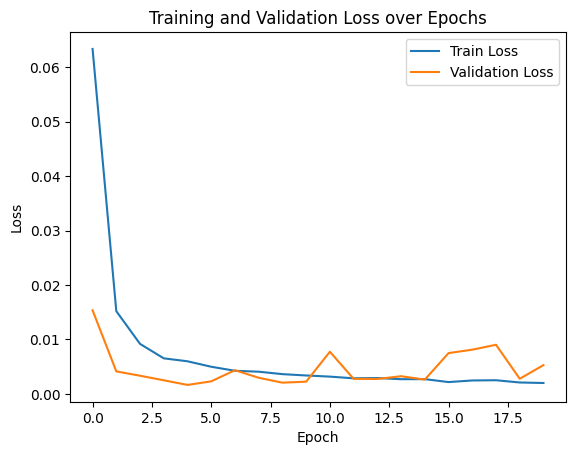

In [7]:
#Training vs Validation loss 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

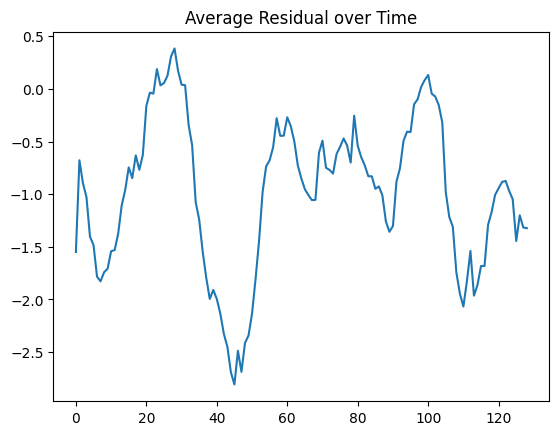

In [8]:
#Residual plot
residuals = y_test_lstm_inv - y_pred_lstm_inv
plt.plot(residuals.mean(axis=1))
plt.title("Average Residual over Time")
plt.show()

In [9]:
for h in range(forecast_horizon):
    rmse = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    mae  = mean_absolute_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    mape = mean_absolute_percentage_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    r2   = r2_score(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    
    print(f"Horizon {h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.2%}, R²={r2:.2%}")

Horizon 1: RMSE=1.3593, MAE=1.0772, MAPE=2.44%, R²=84.43%
Horizon 2: RMSE=1.3365, MAE=1.1254, MAPE=2.43%, R²=85.32%
Horizon 3: RMSE=3.1427, MAE=2.6662, MAPE=5.70%, R²=20.67%
Horizon 4: RMSE=2.9162, MAE=2.7054, MAPE=5.89%, R²=33.24%
Horizon 5: RMSE=2.1607, MAE=1.9066, MAPE=4.23%, R²=64.05%
Horizon 6: RMSE=1.5505, MAE=1.2673, MAPE=2.95%, R²=81.82%
Horizon 7: RMSE=3.3959, MAE=3.0961, MAPE=7.03%, R²=14.28%
Horizon 8: RMSE=2.2836, MAE=1.9765, MAPE=4.42%, R²=62.03%
Horizon 9: RMSE=1.8972, MAE=1.4431, MAPE=3.30%, R²=74.45%
Horizon 10: RMSE=4.6326, MAE=4.1797, MAPE=9.74%, R²=-48.09%
Horizon 11: RMSE=1.8107, MAE=1.4493, MAPE=3.36%, R²=77.89%
Horizon 12: RMSE=2.1542, MAE=1.6614, MAPE=3.93%, R²=69.28%
Horizon 13: RMSE=3.4772, MAE=3.2832, MAPE=7.29%, R²=21.52%
Horizon 14: RMSE=1.3668, MAE=1.1087, MAPE=2.50%, R²=88.10%


XGBoost Model:

In [10]:
xgb_models = []
y_preds_xgb = []
xgb_features_idx = [(raw_features + engineered_features).index(f) for f in engineered_features ]

X_train_xgb = X_train[:,xgb_features_idx]
X_val_xgb = X_val[:,xgb_features_idx]
X_test_xgb = X_test[:,xgb_features_idx]

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 5
}


for step in range(forecast_horizon):
    # target is shifted for each horizon step
    y_train_step = y_train[lookback + step: len(y_train) - forecast_horizon + step + 1]
    y_val_step   = y_val[lookback + step: len(y_val) - forecast_horizon + step + 1]
    y_test_step  = y_test[lookback + step: len(y_test) - forecast_horizon + step + 1]
    
    dtrain = xgb.DMatrix(X_train_xgb[lookback:len(y_train_step)+lookback], label=y_train_step)
    dval   = xgb.DMatrix(X_val_xgb[lookback:len(y_val_step)+lookback], label=y_val_step)
    dtest  = xgb.DMatrix(X_test_xgb[lookback:len(y_test_step)+lookback])

    model_step = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=20,
        verbose_eval=True
    )
    xgb_models.append(model_step)
    y_preds_xgb.append(model_step.predict(dtest))

y_pred_xgb = np.column_stack(y_preds_xgb)  # shape: (samples, horizon)
y_pred_xgb_inv = scaler_y.inverse_transform(y_pred_xgb)

[0]	train-rmse:0.19109	val-rmse:0.03414
[1]	train-rmse:0.17241	val-rmse:0.03085
[2]	train-rmse:0.15555	val-rmse:0.02771
[3]	train-rmse:0.14037	val-rmse:0.02503
[4]	train-rmse:0.12668	val-rmse:0.02254
[5]	train-rmse:0.11434	val-rmse:0.02046
[6]	train-rmse:0.10323	val-rmse:0.01849
[7]	train-rmse:0.09322	val-rmse:0.01675
[8]	train-rmse:0.08419	val-rmse:0.01512
[9]	train-rmse:0.07605	val-rmse:0.01384
[10]	train-rmse:0.06872	val-rmse:0.01256
[11]	train-rmse:0.06212	val-rmse:0.01139
[12]	train-rmse:0.05615	val-rmse:0.01051
[13]	train-rmse:0.05078	val-rmse:0.00966
[14]	train-rmse:0.04594	val-rmse:0.00876
[15]	train-rmse:0.04158	val-rmse:0.00797
[16]	train-rmse:0.03765	val-rmse:0.00734
[17]	train-rmse:0.03411	val-rmse:0.00670
[18]	train-rmse:0.03092	val-rmse:0.00612
[19]	train-rmse:0.02804	val-rmse:0.00566
[20]	train-rmse:0.02543	val-rmse:0.00528
[21]	train-rmse:0.02309	val-rmse:0.00495
[22]	train-rmse:0.02097	val-rmse:0.00461
[23]	train-rmse:0.01906	val-rmse:0.00439
[24]	train-rmse:0.01733	va

Individual model performance:

In [11]:
for h in range(forecast_horizon):
    rmse_lstm = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    rmse_xgb  = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_xgb_inv[:, h])
    r2_lstm = r2_score(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    r2_xgb = r2_score(y_test_lstm_inv[:, h], y_pred_xgb_inv[:, h])
    print(f"H{h+1}: LSTM RMSE={rmse_lstm:.3f} R2={r2_lstm:.3f}| XGB={rmse_xgb:.3f} R2={r2_xgb:.3f}")

H1: LSTM RMSE=1.359 R2=0.844| XGB=0.316 R2=0.992
H2: LSTM RMSE=1.337 R2=0.853| XGB=0.698 R2=0.960
H3: LSTM RMSE=3.143 R2=0.207| XGB=1.048 R2=0.912
H4: LSTM RMSE=2.916 R2=0.332| XGB=1.366 R2=0.854
H5: LSTM RMSE=2.161 R2=0.641| XGB=1.629 R2=0.796
H6: LSTM RMSE=1.551 R2=0.818| XGB=1.828 R2=0.747
H7: LSTM RMSE=3.396 R2=0.143| XGB=2.276 R2=0.615
H8: LSTM RMSE=2.284 R2=0.620| XGB=2.827 R2=0.418
H9: LSTM RMSE=1.897 R2=0.745| XGB=3.243 R2=0.254
H10: LSTM RMSE=4.633 R2=-0.481| XGB=3.169 R2=0.307
H11: LSTM RMSE=1.811 R2=0.779| XGB=2.667 R2=0.520
H12: LSTM RMSE=2.154 R2=0.693| XGB=2.709 R2=0.514
H13: LSTM RMSE=3.477 R2=0.215| XGB=3.050 R2=0.396
H14: LSTM RMSE=1.367 R2=0.881| XGB=3.012 R2=0.422


Ensemble fusion using meta learner stacking to combine LSTM and XGBoost output:

In [12]:
#Not using ensemble fusion 

"""

from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

# LSTM validation prediction
y_pred_val_lstm = lstm_model.predict(X_val_lstm)
y_pred_val_lstm_inv = scaler_y.inverse_transform(
    y_pred_val_lstm.reshape(-1,1)
).reshape(y_pred_val_lstm.shape)

# XGBoost validation prediction
y_preds_val_xgb = []
for step, model_step in enumerate(xgb_models):
    dval = xgb.DMatrix(X_val_xgb[lookback: len(y_val_lstm) + lookback])
    y_preds_val_xgb.append(model_step.predict(dval))

y_pred_val_xgb = np.column_stack(y_preds_val_xgb)
y_pred_val_xgb_inv = scaler_y.inverse_transform(y_pred_val_xgb)

# Prepare validation-level stacking features
# Each has shape (n_val_samples, horizon)
lstm_val_preds = y_pred_val_lstm_inv  # shape (n_samples, horizon)
xgb_val_preds  = y_pred_val_xgb_inv
y_val_lstm_inv = scaler_y.inverse_transform(y_val_lstm.reshape(-1,1)).reshape(y_val_lstm.shape)

# Stack as columns per horizon: we can create features shape (n_samples, 2*horizon) or (n_samples, horizon, 2) with flattening
X_stack_val = np.concatenate([lstm_val_preds, xgb_val_preds], axis=1)  # (n, 2*h)
y_stack_val = y_val_lstm_inv  # true values on validation (shape (n, horizon))

# Train a multioutput Ridge to map stacked preds -> true y
# Simpler: train a multioutput ridge per horizon via MultiOutputRegressor
meta = MultiOutputRegressor(Ridge(alpha=1.0))
meta.fit(X_stack_val, y_stack_val)

# To predict on test:
lstm_test_preds = y_pred_lstm_inv
xgb_test_preds  = y_pred_xgb_inv
X_stack_test = np.concatenate([lstm_test_preds, xgb_test_preds], axis=1)
y_pred_meta = meta.predict(X_stack_test)  # shape (n_test, horizon)

# Produce the 14-day forecast
final_forecast = y_pred_meta[-1]
print("Final hybrid forecast for the next 14 days:", final_forecast)

# Evaluate vs previous hybrid:
for h in range(forecast_horizon):
    rmse_meta = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    print(f"H{h+1}: RMSE_meta={rmse_meta:.4f}")

"""


'\n\nfrom sklearn.linear_model import Ridge\nfrom sklearn.multioutput import MultiOutputRegressor\n\n# LSTM validation prediction\ny_pred_val_lstm = lstm_model.predict(X_val_lstm)\ny_pred_val_lstm_inv = scaler_y.inverse_transform(\n    y_pred_val_lstm.reshape(-1,1)\n).reshape(y_pred_val_lstm.shape)\n\n# XGBoost validation prediction\ny_preds_val_xgb = []\nfor step, model_step in enumerate(xgb_models):\n    dval = xgb.DMatrix(X_val_xgb[lookback: len(y_val_lstm) + lookback])\n    y_preds_val_xgb.append(model_step.predict(dval))\n\ny_pred_val_xgb = np.column_stack(y_preds_val_xgb)\ny_pred_val_xgb_inv = scaler_y.inverse_transform(y_pred_val_xgb)\n\n# Prepare validation-level stacking features\n# Each has shape (n_val_samples, horizon)\nlstm_val_preds = y_pred_val_lstm_inv  # shape (n_samples, horizon)\nxgb_val_preds  = y_pred_val_xgb_inv\ny_val_lstm_inv = scaler_y.inverse_transform(y_val_lstm.reshape(-1,1)).reshape(y_val_lstm.shape)\n\n# Stack as columns per horizon: we can create features

In [13]:
#print(lstm_val_preds.shape, xgb_val_preds.shape, y_val_lstm_inv.shape)
#print(lstm_test_preds.shape, xgb_test_preds.shape, y_test_lstm_inv.shape)

Option 2: Hybrid fusion using error-based weighting

In [ ]:
# --- 1. Get validation predictions ---
# LSTM validation prediction
y_pred_val_lstm = lstm_model.predict(X_val_lstm)
y_pred_val_lstm_inv = scaler_y.inverse_transform(
    y_pred_val_lstm.reshape(-1,1)
).reshape(y_pred_val_lstm.shape)

# XGBoost validation prediction
y_preds_val_xgb = []
for step, model_step in enumerate(xgb_models):
    dval = xgb.DMatrix(X_val_xgb[lookback: len(y_val_lstm) + lookback])
    y_preds_val_xgb.append(model_step.predict(dval))

y_pred_val_xgb = np.column_stack(y_preds_val_xgb)
y_pred_val_xgb_inv = scaler_y.inverse_transform(y_pred_val_xgb)

# --- 2. Compute validation errors per horizon ---
val_errors_lstm = [
        root_mean_squared_error(y_val_lstm[:, h], y_pred_val_lstm_inv[:, h])
            for h in range(forecast_horizon)
            ]
val_errors_xgb = [
        root_mean_squared_error(y_val_lstm[:, h], y_pred_val_xgb_inv[:, h])
            for h in range(forecast_horizon)
            ]


# --- 3. Convert errors into weights (lower error = higher weight) ---
val_errors_lstm = np.array(val_errors_lstm)
val_errors_xgb  = np.array(val_errors_xgb)

weights_lstm = 1 / val_errors_lstm
weights_xgb  = 1 / val_errors_xgb
weights_sum  = weights_lstm + weights_xgb
weights_lstm /= weights_sum
weights_xgb  /= weights_sum

print("Validation Weights (per horizon):")
for h in range(forecast_horizon):
    print(f"H{h+1}: LSTM={weights_lstm[h]:.2f}, XGB={weights_xgb[h]:.2f}")

# --- 4. Apply weights on test predictions ---
y_pred_hybrid_inv = weights_lstm * y_pred_lstm_inv + weights_xgb * y_pred_xgb_inv

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Validation Weights (per horizon):
H1: LSTM=0.49, XGB=0.51
H2: LSTM=0.51, XGB=0.49
H3: LSTM=0.49, XGB=0.51
H4: LSTM=0.51, XGB=0.49
H5: LSTM=0.53, XGB=0.47
H6: LSTM=0.48, XGB=0.52
H7: LSTM=0.48, XGB=0.52
H8: LSTM=0.49, XGB=0.51
H9: LSTM=0.51, XGB=0.49
H10: LSTM=0.48, XGB=0.52
H11: LSTM=0.50, XGB=0.50
H12: LSTM=0.48, XGB=0.52
H13: LSTM=0.52, XGB=0.48
H14: LSTM=0.50, XGB=0.50


In [15]:
for h in range(forecast_horizon):
    rmse_hybrid = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_hybrid_inv[:, h])
    r2_hybrid = r2_score(y_test_lstm_inv[:, h], y_pred_hybrid_inv[:, h])
    print(f"H{h+1}: RMSE_hybrid={rmse_hybrid:.4f} | R2_hybrid={r2_hybrid:.4f}")

H1: RMSE_hybrid=0.7168 | R2_hybrid=0.9567
H2: RMSE_hybrid=0.7649 | R2_hybrid=0.9519
H3: RMSE_hybrid=1.5518 | R2_hybrid=0.8066
H4: RMSE_hybrid=1.5119 | R2_hybrid=0.8206
H5: RMSE_hybrid=1.4248 | R2_hybrid=0.8437
H6: RMSE_hybrid=1.2668 | R2_hybrid=0.8786
H7: RMSE_hybrid=2.1904 | R2_hybrid=0.6434
H8: RMSE_hybrid=1.8512 | R2_hybrid=0.7505
H9: RMSE_hybrid=2.1725 | R2_hybrid=0.6650
H10: RMSE_hybrid=2.5641 | R2_hybrid=0.5463
H11: RMSE_hybrid=1.8541 | R2_hybrid=0.7682
H12: RMSE_hybrid=1.9491 | R2_hybrid=0.7485
H13: RMSE_hybrid=2.7015 | R2_hybrid=0.5263
H14: RMSE_hybrid=1.8614 | R2_hybrid=0.7794


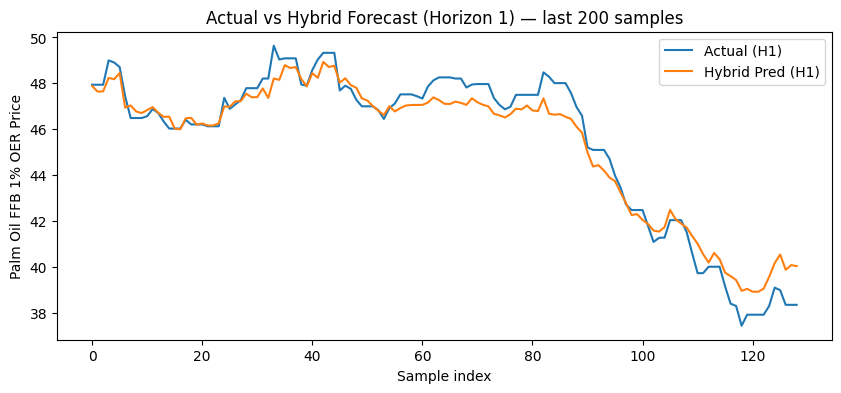

In [16]:
# pick last 200 points from test ground truth and matching predictions (flatten horizon-1 or aggregated)
n = 200
actual = y_test_lstm_inv[-n:, 0]  # horizon-1 actuals
pred_hybrid_h1 = y_pred_hybrid_inv[-n:, 0]

plt.figure(figsize=(10,4))
plt.plot(actual, label="Actual (H1)")
plt.plot(pred_hybrid_h1, label="Hybrid Pred (H1)")
plt.legend()
plt.title("Actual vs Hybrid Forecast (Horizon 1) — last 200 samples")
plt.xlabel("Sample index")
plt.ylabel("Palm Oil FFB 1% OER Price")
plt.show()


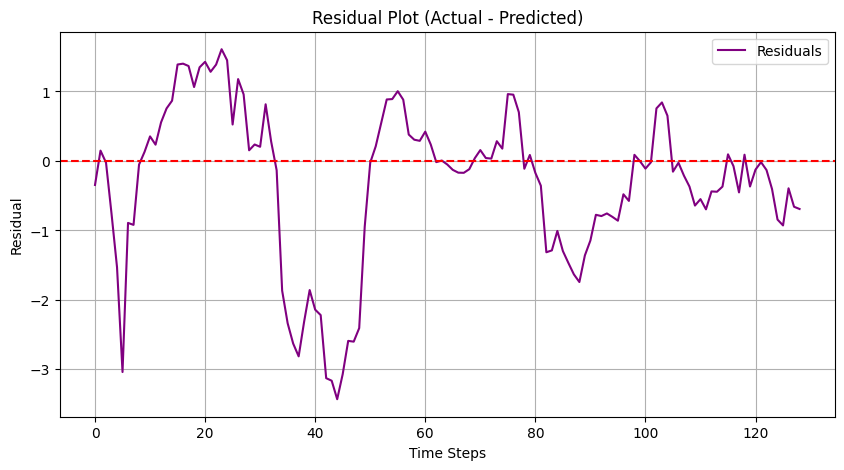

In [17]:
#Residual Plot
avg_actual = np.mean(y_test_lstm_inv, axis=1)
avg_pred = np.mean(y_pred_hybrid_inv, axis=1)

residuals = avg_actual - avg_pred

plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Actual - Predicted)")
plt.xlabel("Time Steps")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.show()

Recommendation Engine:

In [18]:
#Using Meta
"""
ffb = df['ffb_1%_oer']
returns = ffb.pct_change().dropna() * 100

avg_daily_change = returns.mean()
volatility = returns.std()

forecast = y_pred_meta[-1]

def recommendation_engine(current_price, forecast, volatility, k=0.8):
    threshold = k * volatility

    short_term = np.mean(forecast[:3])
    long_term = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    short_change = (short_term - current_price) / current_price * 100
    long_change = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    if short_change < -threshold and long_change < -threshold:
        action = "SELL immediately"
    elif short_change < - threshold and long_change > threshold:
        action = "HOLD harvest (price will rebound later)"
    elif short_change > threshold and long_change <- threshold:
        action = "SELL some and HOLD some (uncertain trend)"
    elif abs(overall_change) < threshold:
        action = "NEUTRAL (The market is stable)"
    else:
        action = "WAIT and monitor"
    
    return {
        "short_term_change": short_change,
        "long_term_change": long_change,
        "overall_change": overall_change,
        "threshold": threshold,
        "recommendation": action
    } 
"""

'\nffb = df[\'ffb_1%_oer\']\nreturns = ffb.pct_change().dropna() * 100\n\navg_daily_change = returns.mean()\nvolatility = returns.std()\n\nforecast = y_pred_meta[-1]\n\ndef recommendation_engine(current_price, forecast, volatility, k=0.8):\n    threshold = k * volatility\n\n    short_term = np.mean(forecast[:3])\n    long_term = np.mean(forecast[7:14])\n    avg_forecast = np.mean(forecast)\n\n    short_change = (short_term - current_price) / current_price * 100\n    long_change = (long_term - current_price) / current_price * 100\n    overall_change = (avg_forecast - current_price) / current_price * 100\n\n    if short_change < -threshold and long_change < -threshold:\n        action = "SELL immediately"\n    elif short_change < - threshold and long_change > threshold:\n        action = "HOLD harvest (price will rebound later)"\n    elif short_change > threshold and long_change <- threshold:\n        action = "SELL some and HOLD some (uncertain trend)"\n    elif abs(overall_change) < th

In [19]:
#Using Hybrid
ffb = df['ffb_1%_oer']
returns = ffb.pct_change().dropna() * 100

y_val_lstm_inv = scaler_y.inverse_transform(y_val_lstm.reshape(-1,1)).reshape(y_val_lstm.shape)

avg_daily_change = returns.mean()
volatility = returns.std()

current_price = y_test_lstm_inv[-1, 0]
forecast = y_pred_hybrid_inv[-1]

def recommendation_engine(current_price, forecast, volatility, k=0.8):
    threshold = k * volatility

    short_term = np.mean(forecast[:3])
    long_term = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    """
    uncertainty = np.std([y_pred_lstm_inv[-1], y_pred_xgb_inv[-1]], axis=0).mean() / current_price * 100
    confidence = max(0, 1 - (uncertainty / volatility))
    confidence = round(confidence * 100, 2)
    """
    avg_error = (val_errors_lstm.mean() + val_errors_xgb.mean()) / 2
    uncertainty = avg_error / np.mean(y_val_lstm_inv)
    volatility = returns.std() / 100  # convert % back to fraction

    confidence = max(0, 1 - uncertainty / volatility)
    confidence = round(confidence * 100, 2)

    short_change = (short_term - current_price) / current_price * 100
    long_change = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    if short_change < -threshold and long_change < -threshold:
        action = "SELL immediately"
    elif short_change < - threshold and long_change > threshold:
        action = "HOLD harvest (price will rebound later)"
    elif short_change > threshold and long_change <- threshold:
        action = "SELL some and HOLD some (uncertain trend)"
    elif abs(overall_change) < threshold:
        action = "NEUTRAL (The market is stable)"
    else:
        action = "WAIT and monitor"
    
    return {
        "short_term_change": short_change,
        "long_term_change": long_change,
        "overall_change": overall_change,
        "threshold": threshold,
        "confidence": confidence,
        "recommendation": action
    } 

In [20]:
current_price = y_test_lstm_inv[-1, 0] 
forecast = y_pred_hybrid_inv[-1]

recommendation = recommendation_engine(current_price, forecast, volatility, k=0.8)

print("\n=== Final Forecast and Recommendation ===")
print("Short-term change: {:.2f}%".format(recommendation["short_term_change"]))
print("long-term change: {:.2f}%".format(recommendation["long_term_change"]))
print("overall change: {:.2f}%".format(recommendation["overall_change"]))
print("Volatility threshold: {:.2f}%".format(recommendation["threshold"]))
print("Confidence level: {:.2f}%".format(recommendation["confidence"]))
print("Recommendation: ",recommendation["recommendation"])
print("Forecasted price for the next 14 days: ", forecast)



=== Final Forecast and Recommendation ===
Short-term change: 1.30%
long-term change: 2.12%
overall change: 1.92%
Volatility threshold: 1.03%
Confidence level: 0.00%
Recommendation:  WAIT and monitor
Forecasted price for the next 14 days:  [40.03777896 38.056276   38.45025911 38.43772621 37.31155376 39.92768509
 40.85689121 40.33446524 37.16237449 42.21758887 39.37207195 40.9870407
 36.06081532 38.00659679]


In [21]:
def recommendation_engine2(
    current_price, 
    forecast, 
    volatility, 
    returns, 
    val_errors_lstm=None, 
    val_errors_xgb=None, 
    k=0.8
):
    """
    Enhanced recommendation engine combining volatility, forecast trend,
    and model uncertainty to give adaptive buy/sell/hold advice.
    """

    # --- STEP 1: Basic stats ---
    short_term = np.mean(forecast[:3])
    long_term  = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    short_change = (short_term - current_price) / current_price * 100
    long_change  = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    # --- STEP 2: Forecast trend strength (slope of 14-day forecast) ---
    slope = np.polyfit(range(len(forecast)), forecast, 1)[0]
    trend_strength = slope / current_price * 100  # normalize to percentage

    # --- STEP 3: Estimate model uncertainty & confidence ---
    if val_errors_lstm is not None and val_errors_xgb is not None:
        avg_error = (np.mean(val_errors_lstm) + np.mean(val_errors_xgb)) / 2
        model_diff = abs(np.mean(val_errors_lstm) - np.mean(val_errors_xgb))
        # Normalize & scale to 0–100
        uncertainty = ((avg_error / current_price) * 30) + (model_diff / avg_error * 20)
    else:
        uncertainty = np.std(forecast) / current_price * 100

    uncertainty = min(uncertainty, 100)

    ratio = (uncertainty / (volatility + 0.5)) / 25  # smoother scaling
    ratio = min(ratio, 1.5)
    confidence = max(0, 1 - ratio)
    confidence = round(confidence * 100, 2)
    
    # --- STEP 4: Detect market regime ---
    avg_daily_change = returns.mean()
    recent_vol = volatility
    base_vol = returns.std()

    if recent_vol > base_vol * 1.3:
        regime = "High Volatility"
        k *= 1.2
    elif avg_daily_change > 0.3:
        regime = "Uptrend"
    elif avg_daily_change < -0.3:
        regime = "Downtrend"
    else:
        regime = "Stable"

    threshold = k * volatility

    # --- STEP 5: Decision logic ---
    if trend_strength > threshold and long_change > threshold:
        action = "BUY — Uptrend forming"
    elif trend_strength < -threshold and long_change < -threshold:
        action = "SELL — Downtrend forming"
    elif short_change < -threshold and long_change > threshold:
        action = "HOLD harvest — temporary dip"
    elif abs(overall_change) < threshold:
        action = "NEUTRAL — Market stable"
    else:
        action = "WAIT — Unclear direction"

    # --- STEP 6: Construct readable output ---
    recommendation = {
        "short_term_change(%)": round(short_change, 2),
        "long_term_change(%)": round(long_change, 2),
        "overall_change(%)": round(overall_change, 2),
        "trend_strength(%)": round(trend_strength, 2),
        "volatility(%)": round(volatility, 2),
        "uncertainty(%)": round(uncertainty, 2),
        "confidence(%)": confidence,
        "market_regime": regime,
        "threshold(%)": round(threshold, 2),
        "recommendation": action
    }

    return recommendation


In [22]:
current_price = y_test_lstm_inv[-1, 0]
forecast = y_pred_hybrid_inv[-1]

recommendation = recommendation_engine2(
    current_price=current_price,
    forecast=forecast,
    volatility=volatility,
    returns=returns,
    val_errors_lstm=val_errors_lstm,
    val_errors_xgb=val_errors_xgb
)

print("\n=== Final Forecast and Recommendation ===")
for k, v in recommendation.items():
    print(f"{k}: {v}")



=== Final Forecast and Recommendation ===
short_term_change(%): 1.3
long_term_change(%): 2.12
overall_change(%): 1.92
trend_strength(%): -0.02
volatility(%): 1.29
uncertainty(%): 30.01
confidence(%): 32.85
market_regime: Stable
threshold(%): 1.03
recommendation: WAIT — Unclear direction


In [23]:
print("Mean LSTM RMSE:", np.mean(val_errors_lstm))
print("Mean XGB RMSE:", np.mean(val_errors_xgb))
print("Current Price:", current_price)

Mean LSTM RMSE: 38.293913688947256
Mean XGB RMSE: 37.88797418593362
Current Price: 38.35
